#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description
In this part of the project, we created 4 ensemble methods and compared them, using statistical analysis methods in 10 different datasets.
#### Ensembles
1. Bagging Ensemble using Random Tree Classifier.  
We follow the procedure described below:
  - Random Search, in order to search fpr hyperparameters.
  - Grid Search in the area near the best parameters found from the Random Search.
  - 10 fold Cross Validation, in order to plot the accuracy vs the number of classifiers used.
  - Prediction using the best estimation for the number of classifiers, combined with the tuned parameters.
2. Random Forest Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters.
3. Stacking, using a Nearest Neighbors classifier, a Linear SVM, a Decision Tree classifier and a Naive Bayes classifier. The Meta-Classifier is a Logistic Regression Classifier.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Present plots of each model's performane to the dataset and compare them with the stacking model, which combines them all.
  - Prediction using the tuned parameters of each model.  
  
  **Note:** TODO describe how the Stacking Library works. (CV to create meta dataset etc.)

4. Boosting, using XGBoost with Logistic Regression.  
We follow the procedure described below:
  - Random Search.
  - Grid Search.
  - Prediction using the tuned parameters of each model.

#### Datasets
1. [Spambase](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data)
2. **Wine** - Using sklearn' s import.
3. **Iris** - Using sklearn' s import.
4. [Breast Cancer](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?fbclid=IwAR2ZT56DdRbU45HMFvq6gwTdjKsS-RLSQ0B1TQM4cskmA27x-upTF0n66BI)
5. [Seeds](https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)
6. [Glass Identification](https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data)
7. [Tic Tac Toe](https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data)
8. [Wholesale Customers](https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv) - Predicting the channel.
9. **Digits** - Using sklearn' s import.
10. [Teaching Assistant Evaluation](https://archive.ics.uci.edu/ml/machine-learning-databases/tae/tae.data)

#### Comparison
TODO describe the comparison procedure.

# Globals


### Import all modules.


In [0]:
import io
import time

import numpy as np
import requests
import seaborn as sns
import xgboost as xgb
from mlxtend.classifier import StackingCVClassifier
from pandas import read_csv
from scipy.stats import randint as sp_randint
from sklearn.datasets import load_wine, load_digits
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

# Import util functions.
from utils import report, estimators_vs_acc, plot_accuracy_stacking, plot_learning_curve, full_report

%matplotlib inline


# Spambase



## Prepare the dataset.


In [0]:
# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1645 tasks      | elapsed:   21.8s


RandomizedSearchCV took 25.62 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.910 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 27, 'max_features': 6, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.908 (std: 0.017)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 42, 'min_samples_split': 23}

Model with rank: 3
Mean validation score: 0.906 (std: 0.019)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 10, 'min_samples_split': 13}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   25.5s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(24, 30),
              'max_features': range(4, 8),
              'min_samples_split': range(7, 12),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    7.9s


GridSearchCV took 20.03 seconds.
Model with rank: 1
Mean validation score: 0.915 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 29, 'max_features': 6, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.911 (std: 0.015)
Parameters: {'criterion': 'entropy', 'max_depth': 26, 'max_features': 6, 'min_samples_split': 11}

Model with rank: 3
Mean validation score: 0.911 (std: 0.017)
Parameters: {'criterion': 'entropy', 'max_depth': 29, 'max_features': 5, 'min_samples_split': 9}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   20.0s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

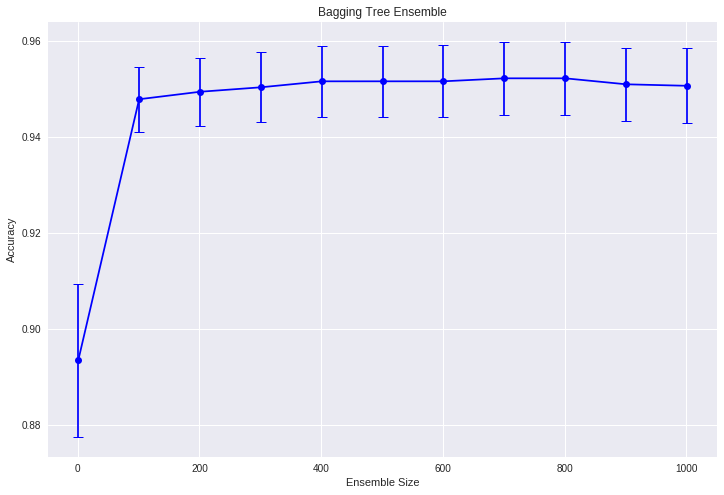

In [0]:

# Add best values for the classifier.
clf.max_depth = 29
clf.max_features = 6
clf.min_samples_split = 7
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators for [100, 200, ..., 1000] estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1100, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 800, since the accuracy is high  
and the lower bound of it's deviation is better than the others.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=800, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9565
Precision      0.9594
Recall         0.9319
F1             0.9455


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.0min finished


RandomizedSearchCV took 783.76 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.936 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 33, 'max_features': 11, 'min_samples_split': 22, 'n_estimators': 118}

Model with rank: 2
Mean validation score: 0.933 (std: 0.033)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 40, 'min_samples_split': 25, 'n_estimators': 280}

Model with rank: 3
Mean validation score: 0.931 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 29, 'max_features': 12, 'min_samples_split': 78, 'n_estimators': 151}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(32, 34),
              'max_features': range(10, 12),
              'min_samples_split': range(21, 23),
              'n_estimators': range(115, 120),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 12.1min finished


GridSearchCV took 727.99 seconds.
Model with rank: 1
Mean validation score: 0.938 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 10, 'min_samples_split': 21, 'n_estimators': 116}

Model with rank: 1
Mean validation score: 0.938 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 10, 'min_samples_split': 21, 'n_estimators': 117}

Model with rank: 1
Mean validation score: 0.938 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 10, 'min_samples_split': 21, 'n_estimators': 118}

Model with rank: 1
Mean validation score: 0.938 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 10, 'min_samples_split': 21, 'n_estimators': 119}

Model with rank: 1
Mean validation score: 0.938 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 11, 'min_samples_split': 22, 'n_estimators': 119}

Model with rank: 1
Mean validation score: 0.938 (std: 0.


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 32
clf.max_features = 10
clf.min_samples_split = 21
clf.n_estimators = 116
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9493
Precision      0.9502
Recall         0.9229
F1             0.9364


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': np.logspace(-3, 3),
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': np.logspace(-3, 3)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 717.96 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.932 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 15, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 79.06043210907701, 'meta-logisticregression__C': 0.21209508879201905}

Model with rank: 2
Mean validation score: 0.931 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 11, 'kneighborsclassifier__n_neighbors': 37, 'linearsvc__C': 19.306977288832496, 'meta-logisticregression__C': 184.20699693267164}

Model with rank: 3
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 18, 'linearsvc__C': 44.98432668969444, 'meta-logisticregression__C': 244.205309454865}



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(39, 41),
              'linearsvc__C': np.logspace(-1, 2, 8),
              'decisiontreeclassifier__max_depth': range(14, 16),
              'meta-logisticregression__C': np.logspace(-1, 2, 4)}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed: 31.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "th

GridSearchCV took 1887.33 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 15, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 100.0, 'meta-logisticregression__C': 0.1}

Model with rank: 2
Mean validation score: 0.932 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 15, 'kneighborsclassifier__n_neighbors': 39, 'linearsvc__C': 100.0, 'meta-logisticregression__C': 0.1}

Model with rank: 3
Mean validation score: 0.932 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 14, 'kneighborsclassifier__n_neighbors': 39, 'linearsvc__C': 100.0, 'meta-logisticregression__C': 10.0}



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Plot stacking results

Accuracy: 0.85 (+/- 0.03) [KNN]
Accuracy: 0.92 (+/- 0.01) [Linear-SVM]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.92 (+/- 0.02) [Decision Tree]
Accuracy: 0.81 (+/- 0.02) [Naive-Bayes]
Accuracy: 0.82 (+/- 0.02) [Logistic Regression]
Accuracy: 0.93 (+/- 0.02) [Stacking]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


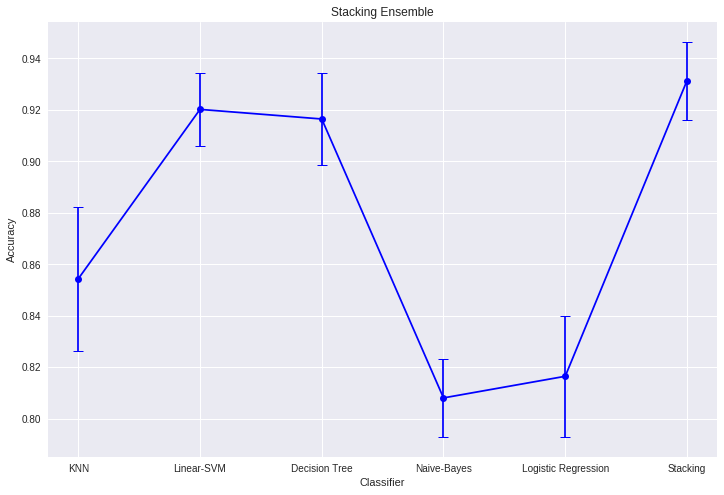

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 40
clf2.C = 100
clf3.max_depth = 15
meta_clf.C = 0.1

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

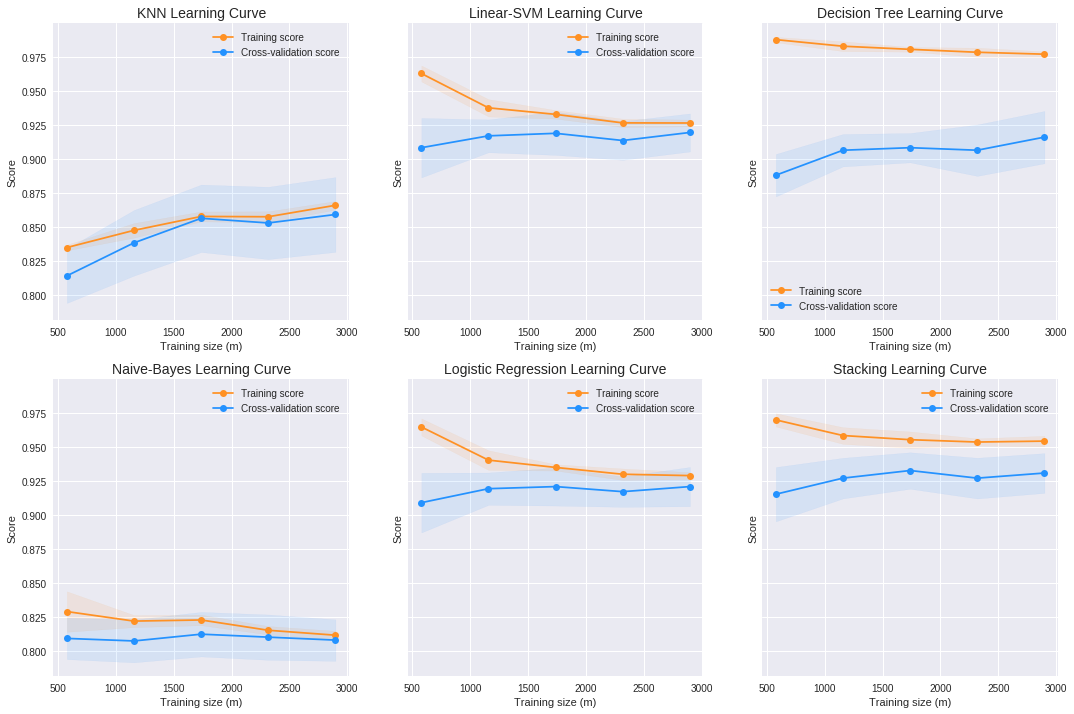

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
clf2.C = 100
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Final Results
---------------------
Accuracy       0.9449
Precision      0.9398
Recall         0.9229
F1             0.9313


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.8min finished


RandomizedSearchCV took 1129.29 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.945 (std: 0.028)
Parameters: {'colsample_bytree': 0.16567284453802777, 'gamma': 1.2897942058134846, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7881392928703552}

Model with rank: 2
Mean validation score: 0.944 (std: 0.027)
Parameters: {'colsample_bytree': 0.689251658754767, 'gamma': 1.2897942058134846, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7881392928703552}

Model with rank: 3
Mean validation score: 0.944 (std: 0.028)
Parameters: {'colsample_bytree': 0.689251658754767, 'gamma': 1.9338983224879844, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.7881392928703552}

Model with rank: 3
Mean validation score: 0.944 (std: 0.028)
Parameters: {'colsample_bytree': 0.7253964391891019, 'gamma': 1.2897942058134846, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.7881392928703552}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(4, 6),
          'gamma': np.arange(1.1, 1.3, 0.1),
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.78
xgb_clf.colsample_bytree = 0.16

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.4min finished


GridSearchCV took 327.01 seconds.
Model with rank: 1
Mean validation score: 0.953 (std: 0.011)
Parameters: {'gamma': 1.1, 'max_depth': 7, 'min_child_weight': 5}

Model with rank: 2
Mean validation score: 0.953 (std: 0.010)
Parameters: {'gamma': 1.2000000000000002, 'max_depth': 7, 'min_child_weight': 5}

Model with rank: 3
Mean validation score: 0.952 (std: 0.010)
Parameters: {'gamma': 1.1, 'max_depth': 6, 'min_child_weight': 5}

Model with rank: 3
Mean validation score: 0.952 (std: 0.009)
Parameters: {'gamma': 1.2000000000000002, 'max_depth': 5, 'min_child_weight': 5}




### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 5
xgb_clf.gamma = 1.1
xgb_clf.max_depth = 7

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9558
Precision      0.9526
Recall         0.9373
F1             0.9449



# Wine



## Prepare the dataset.


In [0]:
# Get x and y.
X, y = load_wine(True)

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 1000

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 7860 tasks      | elapsed:   12.1s


RandomizedSearchCV took 15.56 seconds for 1000 candidates.
Model with rank: 1
Mean validation score: 0.935 (std: 0.058)
Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 2, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 45, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_split': 32}



[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   15.2s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(2, 12),
              'max_features': range(2, 11),
              'min_samples_split': range(25, 40),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 2700 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 7628 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 18788 tasks      | elapsed:   28.1s


GridSearchCV took 40.76 seconds.
Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validation score: 0.935 (std: 0.068)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 4, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.935 (std: 0.048)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 6, 'min_samples_split': 32}

Model with rank: 1
Mean validat

[Parallel(n_jobs=-1)]: Done 27000 out of 27000 | elapsed:   40.6s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

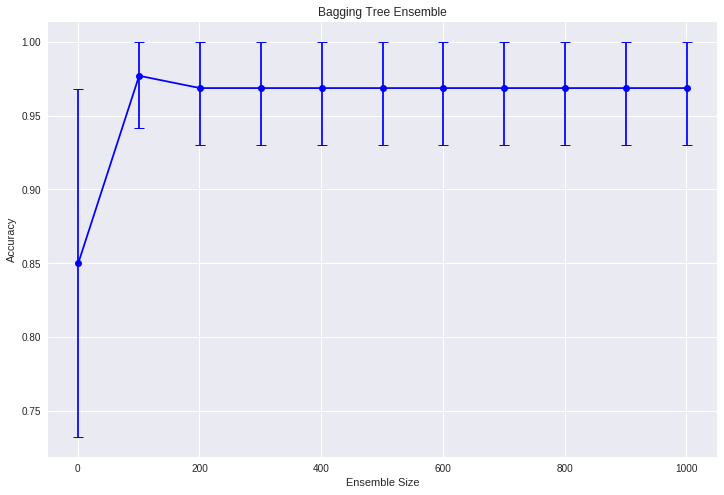

In [0]:

# Add best values for the classifier.
clf.max_depth = 3
clf.max_features = 6
clf.min_samples_split = 32
clf.criterion = 'gini'

# Plot accuracy vs number of estimators for [100, 200, ..., 1000] estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1100, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 100, since the accuracy is high  
and the lower bound of it's deviation is better than the others.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=100, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9595
Recall         0.9697
F1             0.9632


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 311 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 445 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 497 out of 500 | elapsed:   60.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


RandomizedSearchCV took 60.80 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 41, 'max_features': 4, 'min_samples_split': 17, 'n_estimators': 212}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'min_samples_split': 11, 'n_estimators': 168}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 26, 'max_features': 1, 'min_samples_split': 56, 'n_estimators': 157}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 3, 'min_samples_split': 54, 'n_estimators': 202}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 26, 'max_features': 1, 'min_samples_split': 16, 'n_estimators': 131}

Model with rank: 1
Mean validation score: 0.976 (st

### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(36, 40),
              'max_features': range(6, 10),
              'min_samples_split': range(12, 14),
              'n_estimators': range(34, 44, 2),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X, y)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2152 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3016 tasks      | elapsed:  1.9min


GridSearchCV took 122.15 seconds.
Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 12, 'n_estimators': 34}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 12, 'n_estimators': 36}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 12, 'n_estimators': 38}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 12, 'n_estimators': 40}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Parameters: {'criterion': 'entropy', 'max_depth': 36, 'max_features': 6, 'min_samples_split': 13, 'n_estimators': 34}

Model with rank: 1
Mean validation score: 0.978 (std: 0.027)
Param

[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  2.0min finished



### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 36
clf.max_features = 6
clf.min_samples_split = 12
clf.n_estimators = 34
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9595
Recall         0.9697
F1             0.9632


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 50),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   12.4s


RandomizedSearchCV took 15.60 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 44, 'kneighborsclassifier__n_neighbors': 42, 'linearsvc__C': 1, 'meta-logisticregression__C': 100}

Model with rank: 2
Mean validation score: 0.976 (std: 0.052)
Parameters: {'decisiontreeclassifier__max_depth': 29, 'kneighborsclassifier__n_neighbors': 5, 'linearsvc__C': 1, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.976 (std: 0.036)
Parameters: {'decisiontreeclassifier__max_depth': 48, 'kneighborsclassifier__n_neighbors': 33, 'linearsvc__C': 10, 'meta-logisticregression__C': 0.01}

Model with rank: 2
Mean validation score: 0.976 (std: 0.036)
Parameters: {'decisiontreeclassifier__max_depth': 3, 'kneighborsclassifier__n_neighbors': 41, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 2
Mean validation score: 0.976 (std: 0.036)
Parameters: {'decisiontreeclassifier_

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.5s finished


### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(40, 44),
              'decisiontreeclassifier__max_depth': range(42, 46),
              'linearsvc__C': np.logspace(-1, 1, 8),
              'meta-logisticregression__C': range(90, 110, 2)}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 1280 candidates, totalling 12800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1710 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 2502 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3438 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4518 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5742 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 7110 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 8622 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 10278 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 12078 tasks      | elapsed:  6.6min


GridSearchCV took 419.62 seconds.
Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 42, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 0.372759372031494, 'meta-logisticregression__C': 104}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 42, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 0.7196856730011519, 'meta-logisticregression__C': 90}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 42, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 2.6826957952797246, 'meta-logisticregression__C': 90}

Model with rank: 1
Mean validation score: 0.984 (std: 0.032)
Parameters: {'decisiontreeclassifier__max_depth': 42, 'kneighborsclassifier__n_neighbors': 40, 'linearsvc__C': 2.6826957952797246, 'meta-logisticregression__C': 92}

Model with rank: 1
Mean validation score: 0.984 (std: 0.03

[Parallel(n_jobs=-1)]: Done 12800 out of 12800 | elapsed:  7.0min finished


### Plot stacking results

Accuracy: 0.97 (+/- 0.04) [KNN]
Accuracy: 0.96 (+/- 0.05) [Linear-SVM]
Accuracy: 0.91 (+/- 0.08) [Decision Tree]
Accuracy: 0.98 (+/- 0.05) [Naive-Bayes]
Accuracy: 0.95 (+/- 0.06) [Logistic Regression]
Accuracy: 0.98 (+/- 0.03) [Stacking]


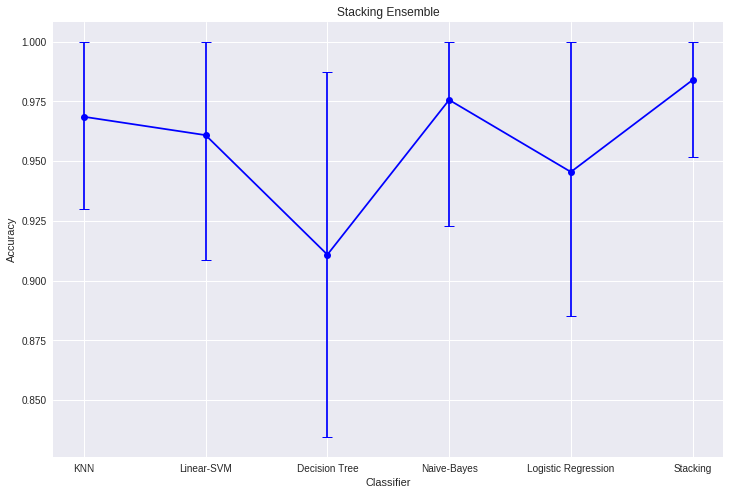

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 42
clf2.C = 1
clf3.max_depth = 44
meta_clf.C = 100

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, we notice that the logistic regression model would not have managed to classify the samples well. However, it is very useful for the classification of the meta-samples. By changing the value of C above to 0.1, it becomes clear, because the model's accuracy to the initial data becomes higher, while the stacking model's accuracy decreases.


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9630
Precision      0.9683
Recall         0.9697
F1             0.9675


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  2.8min


RandomizedSearchCV took 184.33 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'colsample_bytree': 0.23189377429289215, 'gamma': 2.7347955306478076, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8294913612918569}

Model with rank: 2
Mean validation score: 0.968 (std: 0.039)
Parameters: {'colsample_bytree': 0.8580386594231928, 'gamma': 1.6451000509449922, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9038908214954662}

Model with rank: 2
Mean validation score: 0.968 (std: 0.039)
Parameters: {'colsample_bytree': 0.5795228703446513, 'gamma': 2.1860461943795784, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.6318090916325696}

Model with rank: 2
Mean validation score: 0.968 (std: 0.052)
Parameters: {'colsample_bytree': 0.4431134481072303, 'gamma': 2.7347955306478076, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6318090916325696}

Model with rank: 2
Mean validation score: 0.968 (std: 0.039)
Parameters: {'c

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.1min finished


### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(7, 12),
          'gamma': np.arange(2.6, 2.8, 0.1),
          'max_depth': range(2, 4)}
xgb_clf.subsample = 0.82
xgb_clf.colsample_bytree = 0.23

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   11.8s


GridSearchCV took 17.83 seconds.
Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.6, 'max_depth': 2, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.6, 'max_depth': 2, 'min_child_weight': 8}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.6, 'max_depth': 3, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.6, 'max_depth': 3, 'min_child_weight': 8}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.7, 'max_depth': 2, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.7, 'max_depth': 2, 'min_child_weight': 8}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters: {'gamma': 2.7, 'max_depth': 3, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.976 (std: 0.036)
Parameters

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.7s finished



### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 7
xgb_clf.gamma = 2.6
xgb_clf.max_depth = 2

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9444
Precision      0.9444
Recall         0.9545
F1             0.9466



# Iris



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

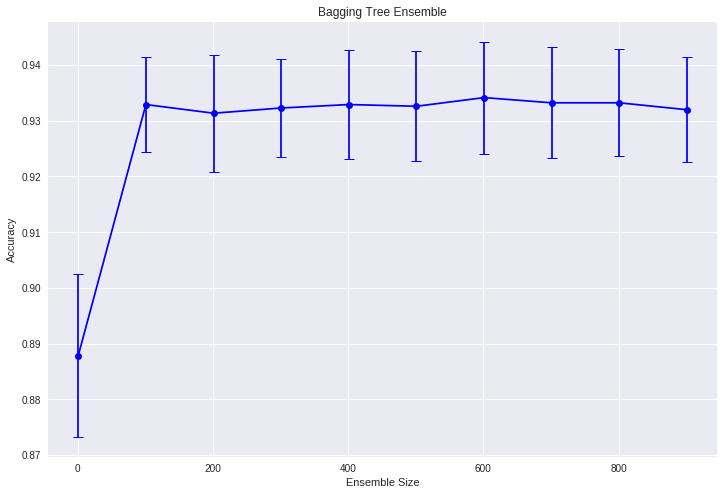

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Breast Cancer


## Prepare the dataset

In [0]:
data = read_csv('C:/Users/User/Desktop/Project Advanced Topics in Ai/datasets/breast-cancer-wisconsin-data/data.csv')
y = data['diagnosis']
unnecessary = ['Unnamed: 32','id','diagnosis']
X = data.drop(unnecessary,axis = 1 )
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

### Visualize number of data per class

Number of Benign:  357
Number of Malignant :  212


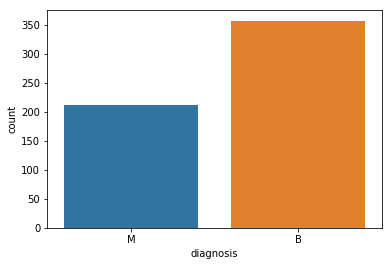

In [0]:
ax = sns.countplot(y,label="Count")       # M = 212, B = 357
B, M = y.value_counts()
print('Number of Benign: ',B)
print('Number of Malignant : ',M)

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

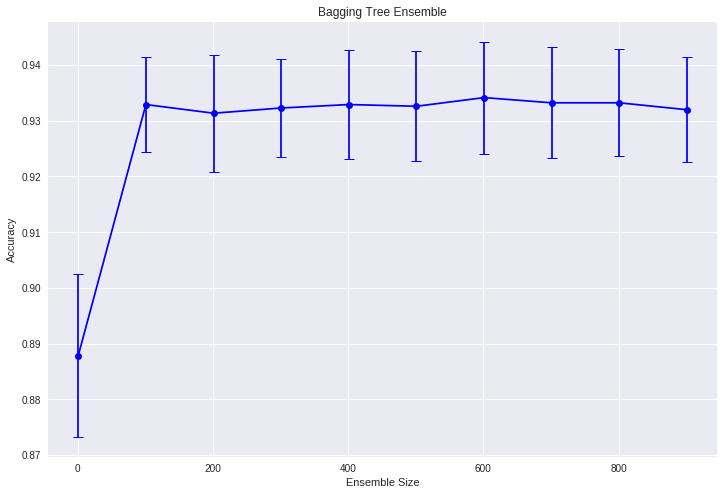

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Seeds



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')), sep='\t+', engine='python', lineterminator='\n')

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1212 tasks      | elapsed:    1.7s


RandomizedSearchCV took 2.62 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 5, 'min_samples_split': 45}

Model with rank: 2
Mean validation score: 0.932 (std: 0.067)
Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 4, 'min_samples_split': 45}

Model with rank: 2
Mean validation score: 0.932 (std: 0.067)
Parameters: {'criterion': 'gini', 'max_depth': 23, 'max_features': 4, 'min_samples_split': 44}

Model with rank: 2
Mean validation score: 0.932 (std: 0.067)
Parameters: {'criterion': 'gini', 'max_depth': 17, 'max_features': 4, 'min_samples_split': 43}

Model with rank: 2
Mean validation score: 0.932 (std: 0.059)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 15}

Model with rank: 2
Mean validation score: 0.932 (std: 0.059)
Parameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 5, 'min_samples_split': 47}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.5s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(7, 15),
              'max_features': range(1, X.shape[1]),
              'min_samples_split': range(35, 55),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 1920 candidates, totalling 19200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 7608 tasks      | elapsed:   10.9s


GridSearchCV took 24.98 seconds.
Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_split': 45}

Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_split': 46}

Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_split': 45}

Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'min_samples_split': 46}

Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 5, 'min_samples_split': 45}

Model with rank: 1
Mean validation score: 0.938 (std: 0.055)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 5, 'min_samples_split': 46}

Model with rank: 1
Mean validat

[Parallel(n_jobs=-1)]: Done 19200 out of 19200 | elapsed:   24.9s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

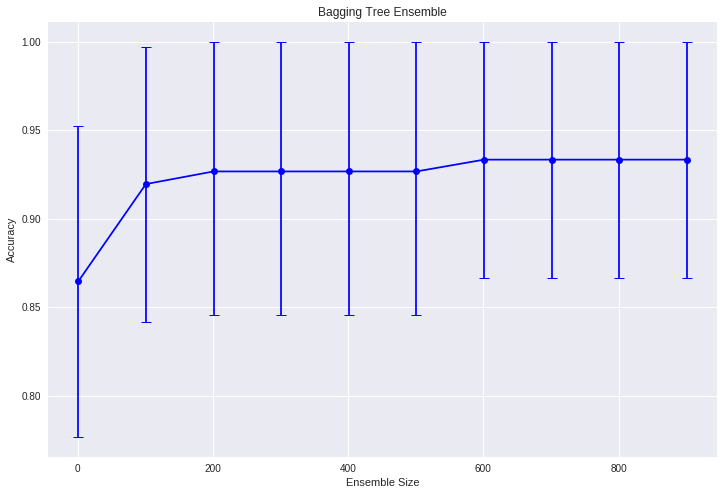

In [0]:

# Add best values for the classifier.
clf.max_depth = 7
clf.max_features = 5
clf.min_samples_split = 45
clf.criterion = 'gini'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

*Note:* The method in this dataset seems to result in a model with big variance.

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.8413
Precision      0.8449
Recall         0.8413
F1             0.8427


Due to the big vaiance of the model, the result is lower than the expected, but within the accepted limits.

## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   44.2s


RandomizedSearchCV took 50.04 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 27, 'max_features': 5, 'min_samples_split': 49, 'n_estimators': 132}

Model with rank: 2
Mean validation score: 0.932 (std: 0.067)
Parameters: {'criterion': 'gini', 'max_depth': 23, 'max_features': 6, 'min_samples_split': 46, 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.932 (std: 0.060)
Parameters: {'criterion': 'gini', 'max_depth': 26, 'max_features': 5, 'min_samples_split': 75, 'n_estimators': 290}

Model with rank: 2
Mean validation score: 0.932 (std: 0.079)
Parameters: {'criterion': 'entropy', 'max_depth': 37, 'max_features': 3, 'min_samples_split': 37, 'n_estimators': 73}

Model with rank: 2
Mean validation score: 0.932 (std: 0.079)
Parameters: {'criterion': 'entropy', 'max_depth': 32, 'max_features': 4, 'min_samples_split': 35, 'n_estimators': 34}

Model with rank: 2
Mean validation score: 0.932

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.9s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(23, 31),
              'max_features': range(4, 6),
              'min_samples_split': range(47, 51),
              'n_estimators': range(110, 160, 10),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 640 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  

GridSearchCV took 620.24 seconds.
Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 5, 'min_samples_split': 47, 'n_estimators': 120}

Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 5, 'min_samples_split': 47, 'n_estimators': 130}

Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 5, 'min_samples_split': 47, 'n_estimators': 140}

Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 5, 'min_samples_split': 47, 'n_estimators': 150}

Model with rank: 1
Mean validation score: 0.938 (std: 0.063)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 5, 'min_samples_split': 48, 'n_estimators': 120}

Model with rank: 1
Mean validation score: 0.938 (std: 0.063)



### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 30
clf.max_features = 5
clf.min_samples_split = 50
clf.n_estimators = 130
clf.criterion = 'gini'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.8571
Precision      0.8609
Recall         0.8571
F1             0.8581


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, X.shape[1]),
              'linearsvc__C': np.logspace(-3, 3),
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': np.logspace(-3, 3)}

candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 453 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 633 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 837 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1317 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1593 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1893 tasks      | elapsed:   50.3s


RandomizedSearchCV took 53.17 seconds, for 200 candidates.
Model with rank: 1
Mean validation score: 0.945 (std: 0.045)
Parameters: {'decisiontreeclassifier__max_depth': 32, 'kneighborsclassifier__n_neighbors': 4, 'linearsvc__C': 184.20699693267164, 'meta-logisticregression__C': 25.595479226995334}

Model with rank: 1
Mean validation score: 0.945 (std: 0.054)
Parameters: {'decisiontreeclassifier__max_depth': 41, 'kneighborsclassifier__n_neighbors': 4, 'linearsvc__C': 754.3120063354608, 'meta-logisticregression__C': 4.714866363457395}

Model with rank: 3
Mean validation score: 0.938 (std: 0.047)
Parameters: {'decisiontreeclassifier__max_depth': 8, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 184.20699693267164, 'meta-logisticregression__C': 3.5564803062231287}

Model with rank: 3
Mean validation score: 0.938 (std: 0.051)
Parameters: {'decisiontreeclassifier__max_depth': 23, 'kneighborsclassifier__n_neighbors': 2, 'linearsvc__C': 10.985411419875572, 'meta-logisticregression__C

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   53.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 6),
              'linearsvc__C': range(170, 190, 4),
              'decisiontreeclassifier__max_depth': range(30, 35),
              'meta-logisticregression__C': [20, 30, 2]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 375 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 561 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1713 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 2505 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3441 tasks      | elapsed:  1.8min


GridSearchCV took 119.29 seconds.
Model with rank: 1
Mean validation score: 0.952 (std: 0.060)
Parameters: {'decisiontreeclassifier__max_depth': 31, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 178, 'meta-logisticregression__C': 30}

Model with rank: 1
Mean validation score: 0.952 (std: 0.056)
Parameters: {'decisiontreeclassifier__max_depth': 32, 'kneighborsclassifier__n_neighbors': 5, 'linearsvc__C': 170, 'meta-logisticregression__C': 20}

Model with rank: 1
Mean validation score: 0.952 (std: 0.048)
Parameters: {'decisiontreeclassifier__max_depth': 33, 'kneighborsclassifier__n_neighbors': 5, 'linearsvc__C': 170, 'meta-logisticregression__C': 30}

Model with rank: 1
Mean validation score: 0.952 (std: 0.048)
Parameters: {'decisiontreeclassifier__max_depth': 33, 'kneighborsclassifier__n_neighbors': 5, 'linearsvc__C': 174, 'meta-logisticregression__C': 2}



[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed:  2.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Plot stacking results

Accuracy: 0.94 (+/- 0.06) [KNN]
Accuracy: 0.96 (+/- 0.05) [Linear-SVM]
Accuracy: 0.88 (+/- 0.09) [Decision Tree]
Accuracy: 0.91 (+/- 0.04) [Naive-Bayes]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.92 (+/- 0.05) [Logistic Regression]
Accuracy: 0.95 (+/- 0.04) [Stacking]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


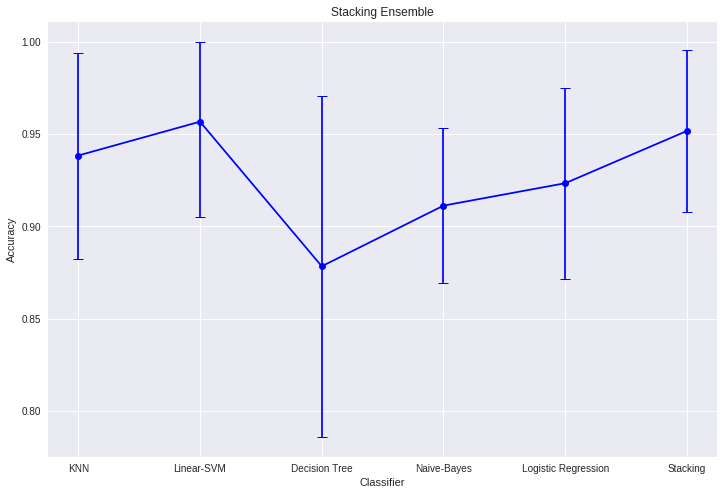

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 5
clf2.C = 170
clf3.max_depth = 33
meta_clf.C = 30

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

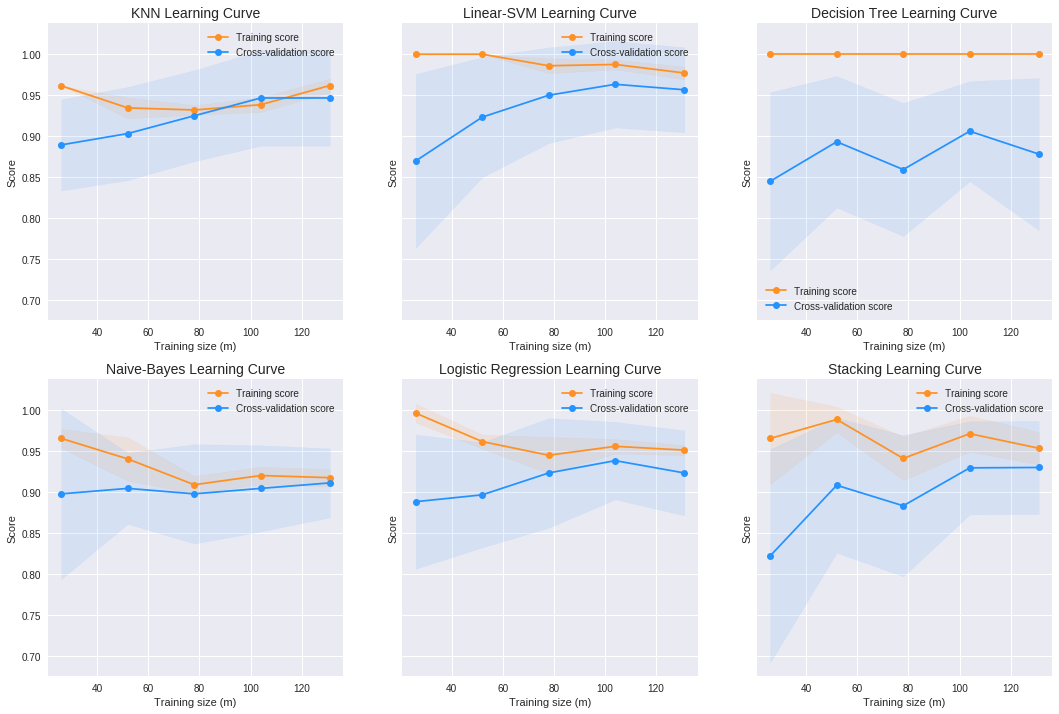

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9365
Precision      0.9407
Recall         0.9365
F1             0.9360


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   19.3s


RandomizedSearchCV took 32.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.627347483473259, 'gamma': 0.796524287009257, 'max_depth': 1, 'min_child_weight': 14, 'subsample': 0.8203228257161057}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.9058224132962325, 'gamma': 1.0708563183535609, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8203228257161057}

Model with rank: 1
Mean validation score: 0.932 (std: 0.059)
Parameters: {'colsample_bytree': 0.9058224132962325, 'gamma': 0.796524287009257, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.8203228257161057}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.4s finished


### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(12, 16),
          'gamma': [0.5, 1.6, 0.2],
          'colsample_bytree': np.arange(0.5, 0.7, 0.05),
          'max_depth': range(4, 6)}
xgb_clf.subsample = 0.82
xgb_clf.colsample_bytree = 0.62

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.1min


GridSearchCV took 69.92 seconds.
Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'max_depth': 4, 'min_child_weight': 12}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.5, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 12}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.55, 'gamma': 0.2, 'max_depth': 4, 'min_child_weight': 12}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.55, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 12}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.6000000000000001, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.932 (std: 0.043)
Parameters: {'colsample_bytree': 0.6000000000000001, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 14}

Model with 

[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.2min finished



### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 0.2
xgb_clf.max_depth = 4
xgb_clf.colsample_bytree = 0.65

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9048
Precision      0.9069
Recall         0.9048
F1             0.9055



# Glass Identification



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

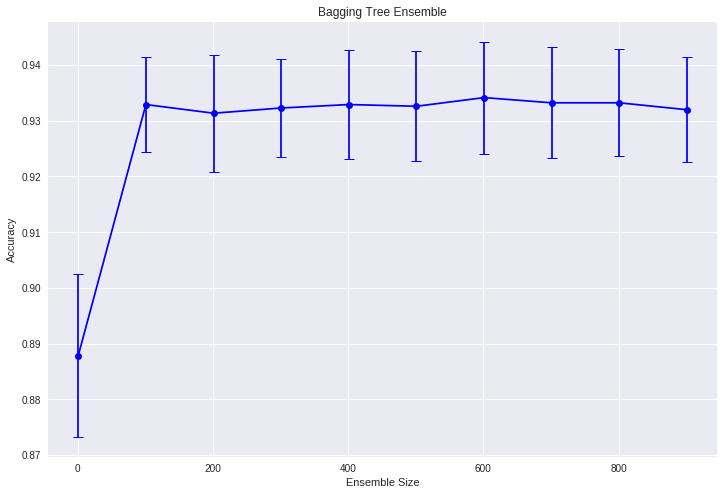

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.4min finished


GridSearchCV took 1473.75 seconds.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 22, 'max_features': 31, 'min_samples_split': 25, 'n_estimators': 245}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 240}

Model with rank: 1
Mean validation score: 0.933 (std: 0.036)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 30, 'min_samples_split': 26, 'n_estimators': 245}




### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Tic Tac Toe



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

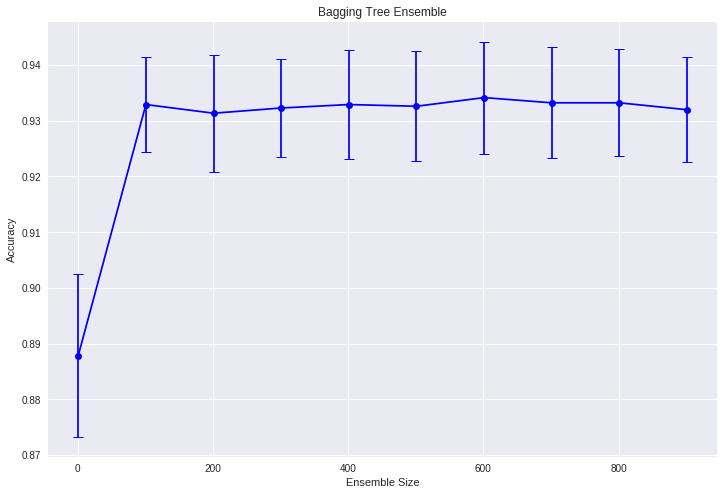

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.7min finished


RandomizedSearchCV took 768.53 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.944 (std: 0.031)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6576692298546599}

Model with rank: 2
Mean validation score: 0.943 (std: 0.029)
Parameters: {'colsample_bytree': 0.6838574847449554, 'gamma': 2.505573562557329, 'max_depth': 6, 'min_child_weight': 14, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.033)
Parameters: {'colsample_bytree': 0.8029175291011409, 'gamma': 2.505573562557329, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.6576692298546599}

Model with rank: 3
Mean validation score: 0.943 (std: 0.031)
Parameters: {'colsample_bytree': 0.3384404594952527, 'gamma': 2.505573562557329, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6576692298546599}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 14.9min finished


GridSearchCV took 899.75 seconds.
Model with rank: 1
Mean validation score: 0.944 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 3, 'min_child_weight': 13}

Model with rank: 1
Mean validation score: 0.944 (std: 0.013)
Parameters: {'gamma': 2.6, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.012)
Parameters: {'gamma': 2.4, 'max_depth': 4, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.4, 'max_depth': 6, 'min_child_weight': 13}

Model with rank: 3
Mean validation score: 0.943 (std: 0.013)
Parameters: {'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 13}



*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331



# Wholesale Customers



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and channel column as y.
X, y = dataset.iloc[:, 1:].values, dataset.iloc[:, 0].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RandomizedSearchCV took 2.58 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 47}

Model with rank: 2
Mean validation score: 0.916 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 5, 'min_samples_split': 90}

Model with rank: 2
Mean validation score: 0.916 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 26, 'max_features': 4, 'min_samples_split': 67}

Model with rank: 2
Mean validation score: 0.916 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 6, 'min_samples_split': 61}

Model with rank: 2
Mean validation score: 0.916 (std: 0.026)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 41}

Model with rank: 2
Mean validation score: 0.916 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'min_samples_sp

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.5s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(1, 7),
              'max_features': range(1, 8),
              'min_samples_split': range(35, 55),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 12037 tasks      | elapsed:   18.7s


GridSearchCV took 26.47 seconds.
Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 35}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 36}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 37}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 38}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 39}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 3, 'min_samples_split': 40}

Model with ra

[Parallel(n_jobs=-1)]: Done 16800 out of 16800 | elapsed:   26.4s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

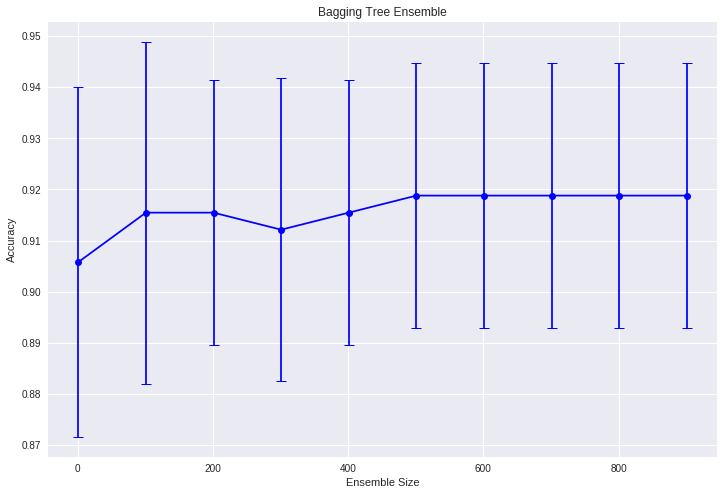

In [0]:

# Add best values for the classifier.
clf.max_depth = 6
clf.max_features = 4
clf.min_samples_split = 48
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 500 - 900.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.8788
Precision      0.8889
Recall         0.9302
F1             0.9091


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   46.0s


RandomizedSearchCV took 62.35 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.922 (std: 0.034)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 2, 'min_samples_split': 148, 'n_estimators': 189}

Model with rank: 2
Mean validation score: 0.919 (std: 0.033)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 2, 'min_samples_split': 32, 'n_estimators': 156}

Model with rank: 2
Mean validation score: 0.919 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 2, 'min_samples_split': 41, 'n_estimators': 236}

Model with rank: 2
Mean validation score: 0.919 (std: 0.029)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'min_samples_split': 170, 'n_estimators': 249}

Model with rank: 2
Mean validation score: 0.919 (std: 0.027)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 6, 'min_samples_split': 3, 'n_estimators': 92}

Model with rank: 2
Mean validation score: 0.919 (s

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(28, 34),
              'max_features': range(3, 5),
              'min_samples_split': range(7, 9),
              'n_estimators': range(155, 160),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 757 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  

GridSearchCV took 356.22 seconds.
Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 155}

Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 156}

Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 157}

Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 158}

Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 4, 'min_samples_split': 7, 'n_estimators': 159}

Model with rank: 1
Mean validation score: 0.925 (std: 0.021)
Param


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 28
clf.max_features = 4
clf.min_samples_split = 7
clf.n_estimators = 155
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9015
Precision      0.9195
Recall         0.9302
F1             0.9249


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 80),
              'linearsvc__C': np.logspace(-3, 3, 1000),
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': np.logspace(-3, 3, 1000)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:   13.3s


RandomizedSearchCV took 14.38 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.922 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 53, 'kneighborsclassifier__n_neighbors': 18, 'linearsvc__C': 359.38136638046257, 'meta-logisticregression__C': 0.037982153061907345}

Model with rank: 1
Mean validation score: 0.922 (std: 0.030)
Parameters: {'decisiontreeclassifier__max_depth': 56, 'kneighborsclassifier__n_neighbors': 11, 'linearsvc__C': 0.18376562003881705, 'meta-logisticregression__C': 0.17875255259042355}

Model with rank: 3
Mean validation score: 0.919 (std: 0.041)
Parameters: {'decisiontreeclassifier__max_depth': 58, 'kneighborsclassifier__n_neighbors': 11, 'linearsvc__C': 0.005329994080844088, 'meta-logisticregression__C': 13.556017853293689}

Model with rank: 3
Mean validation score: 0.919 (std: 0.033)
Parameters: {'decisiontreeclassifier__max_depth': 6, 'kneighborsclassifier__n_neighbors': 58, 'linearsvc__C': 5.220567527846975, 'meta-logisticreg

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(14, 22),
              'linearsvc__C': range(356, 362, 2),
              'decisiontreeclassifier__max_depth': range(51, 55),
              'meta-logisticregression__C': np.arange(0.01, 0.04, 0.01)}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1124 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2564 tasks      | elapsed:  1.4min


GridSearchCV took 97.56 seconds.
Model with rank: 1
Mean validation score: 0.925 (std: 0.025)
Parameters: {'decisiontreeclassifier__max_depth': 51, 'kneighborsclassifier__n_neighbors': 14, 'linearsvc__C': 356, 'meta-logisticregression__C': 0.03}

Model with rank: 1
Mean validation score: 0.925 (std: 0.025)
Parameters: {'decisiontreeclassifier__max_depth': 51, 'kneighborsclassifier__n_neighbors': 14, 'linearsvc__C': 358, 'meta-logisticregression__C': 0.03}

Model with rank: 1
Mean validation score: 0.925 (std: 0.025)
Parameters: {'decisiontreeclassifier__max_depth': 51, 'kneighborsclassifier__n_neighbors': 14, 'linearsvc__C': 360, 'meta-logisticregression__C': 0.03}

Model with rank: 1
Mean validation score: 0.925 (std: 0.025)
Parameters: {'decisiontreeclassifier__max_depth': 51, 'kneighborsclassifier__n_neighbors': 15, 'linearsvc__C': 358, 'meta-logisticregression__C': 0.03}

Model with rank: 1
Mean validation score: 0.925 (std: 0.025)
Parameters: {'decisiontreeclassifier__max_depth': 

[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Plot stacking results

Accuracy: 0.92 (+/- 0.05) [KNN]
Accuracy: 0.91 (+/- 0.04) [Linear-SVM]
Accuracy: 0.85 (+/- 0.03) [Decision Tree]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.90 (+/- 0.05) [Naive-Bayes]
Accuracy: 0.69 (+/- 0.01) [Logistic Regression]
Accuracy: 0.93 (+/- 0.03) [Stacking]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


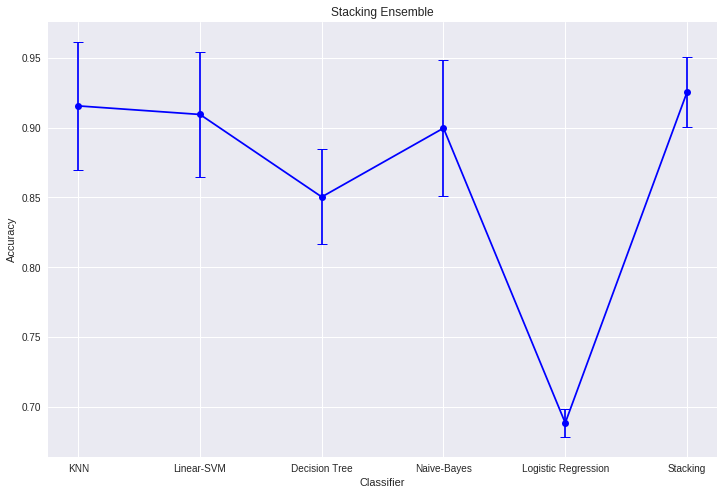

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 14
clf2.C = 356
clf3.max_depth = 51
meta_clf.C = 0.03

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

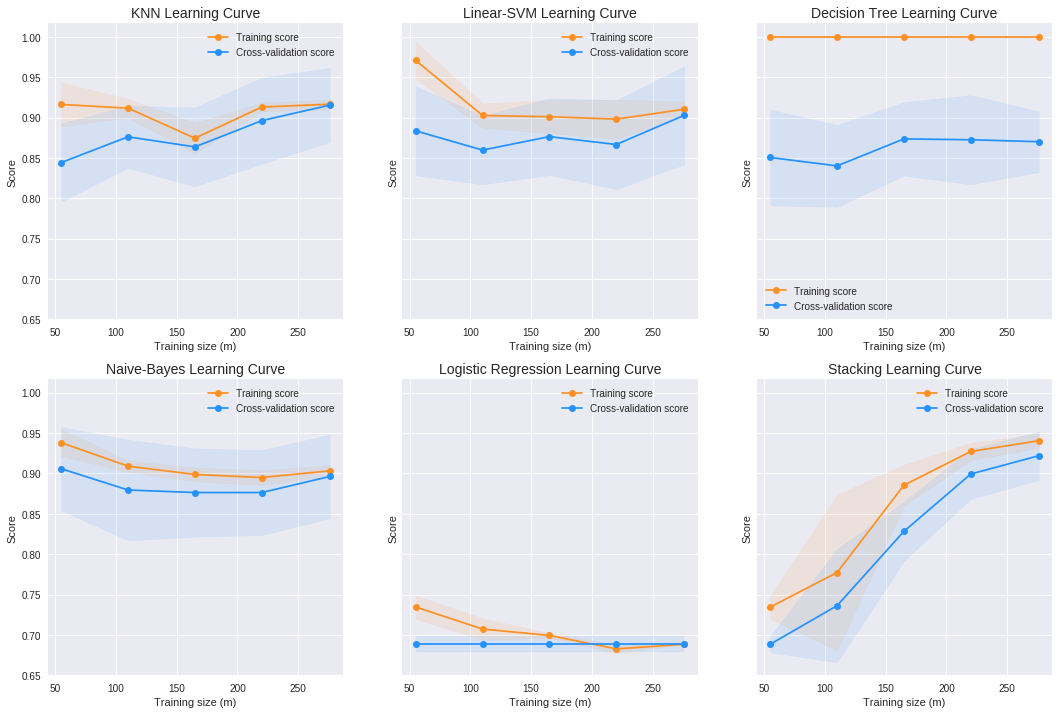

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9091
Precision      0.8936
Recall         0.9767
F1             0.9333


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    7.6s


RandomizedSearchCV took 16.91 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.922 (std: 0.033)
Parameters: {'colsample_bytree': 0.025858808826812463, 'gamma': 3.8262060783107783, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8978767859543505}

Model with rank: 1
Mean validation score: 0.922 (std: 0.035)
Parameters: {'colsample_bytree': 0.7415567122920739, 'gamma': 3.582920733247368, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.7001996451982843}

Model with rank: 1
Mean validation score: 0.922 (std: 0.029)
Parameters: {'colsample_bytree': 0.7415567122920739, 'gamma': 3.582920733247368, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.24611401104063813}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished


### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(2, 8),
          'gamma': np.arange(2, 4, 0.2),
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.24
xgb_clf.colsample_bytree = 0.74

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 420 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1684 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2656 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3844 tasks      | elapsed:  2.3min


GridSearchCV took 153.45 seconds.
Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 1, 'min_child_weight': 2}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 1, 'min_child_weight': 3}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 1, 'min_child_weight': 4}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 2, 'min_child_weight': 2}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 2, 'min_child_weight': 3}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 2, 'min_child_weight': 4}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameters: {'gamma': 2.0, 'max_depth': 3, 'min_child_weight': 3}

Model with rank: 1
Mean validation score: 0.925 (std: 0.032)
Parameter

[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:  2.6min finished



### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 2
xgb_clf.gamma = 2
xgb_clf.max_depth = 1

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred, 'binary')

Final Results
---------------------
Accuracy       0.9091
Precision      0.9022
Recall         0.9651
F1             0.9326


# Digits


## Prepare the dataset.


In [0]:
# Get x and y.
X, y = load_digits(return_X_y=True)

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

pca = PCA(0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 80),
              'max_features': sp_randint(1, X_train.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1153 tasks      | elapsed:   20.4s


RandomizedSearchCV took 34.00 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.846 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 26, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.826 (std: 0.037)
Parameters: {'criterion': 'entropy', 'max_depth': 60, 'max_features': 24, 'min_samples_split': 48}

Model with rank: 3
Mean validation score: 0.821 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 54, 'max_features': 17, 'min_samples_split': 47}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   33.8s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(10, 16),
              'max_features': range(22, 28),
              'min_samples_split': range(10, 14),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1960 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  1.6min


GridSearchCV took 113.37 seconds.
Model with rank: 1
Mean validation score: 0.866 (std: 0.017)
Parameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 24, 'min_samples_split': 12}

Model with rank: 2
Mean validation score: 0.864 (std: 0.019)
Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_features': 24, 'min_samples_split': 13}

Model with rank: 3
Mean validation score: 0.862 (std: 0.022)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 24, 'min_samples_split': 12}

Model with rank: 3
Mean validation score: 0.862 (std: 0.021)
Parameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 24, 'min_samples_split': 13}



[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.9min finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   42.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

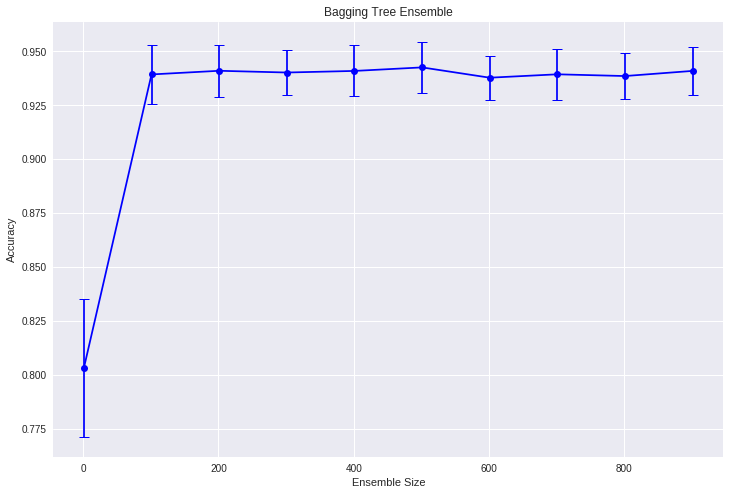

In [0]:

# Add best values for the classifier.
clf.max_depth = 15
clf.max_features = 24
clf.min_samples_split = 12
clf.criterion = 'gini'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 500, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=500, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9296
Precision      0.9329
Recall         0.9314
F1             0.9311


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X_train.shape[1]),
              'min_samples_split': sp_randint(2, X_train.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.7min finished


RandomizedSearchCV took 886.38 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.952 (std: 0.017)
Parameters: {'criterion': 'entropy', 'max_depth': 28, 'max_features': 6, 'min_samples_split': 7, 'n_estimators': 133}

Model with rank: 2
Mean validation score: 0.947 (std: 0.014)
Parameters: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'min_samples_split': 20, 'n_estimators': 138}

Model with rank: 3
Mean validation score: 0.942 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 12, 'max_features': 19, 'min_samples_split': 14, 'n_estimators': 106}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(27, 29),
              'max_features': range(5, 7),
              'n_estimators': range(129, 139, 2),
              'criterion': ['entropy', 'gini']}

clf.min_samples_split = 7

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.3min finished


GridSearchCV took 380.08 seconds.
Model with rank: 1
Mean validation score: 0.965 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 27, 'max_features': 6, 'n_estimators': 129}

Model with rank: 1
Mean validation score: 0.965 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 28, 'max_features': 6, 'n_estimators': 129}

Model with rank: 3
Mean validation score: 0.964 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 27, 'max_features': 6, 'n_estimators': 133}

Model with rank: 3
Mean validation score: 0.964 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 27, 'max_features': 6, 'n_estimators': 135}

Model with rank: 3
Mean validation score: 0.964 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 27, 'max_features': 6, 'n_estimators': 137}

Model with rank: 3
Mean validation score: 0.964 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': 28, 'max_features': 6, 'n_estimators': 133}

Model with rank: 3
Mean validation score: 0.964 


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 27
clf.max_features = 6
clf.n_estimators = 129
clf.criterion = 'gini'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9648
Precision      0.9661
Recall         0.9665
F1             0.9658


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 80),
              'linearsvc__C': np.logspace(-3, 3, 1000),
              'decisiontreeclassifier__max_depth': sp_randint(2, 80),
              'meta-logisticregression__C': np.logspace(-3, 3, 1000)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3

RandomizedSearchCV took 184.78 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.900 (std: 0.033)
Parameters: {'decisiontreeclassifier__max_depth': 13, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 0.14526539259467813, 'meta-logisticregression__C': 123.90621569479157}

Model with rank: 2
Mean validation score: 0.895 (std: 0.034)
Parameters: {'decisiontreeclassifier__max_depth': 49, 'kneighborsclassifier__n_neighbors': 5, 'linearsvc__C': 13.744790926775366, 'meta-logisticregression__C': 304.42722120643}

Model with rank: 3
Mean validation score: 0.878 (std: 0.029)
Parameters: {'decisiontreeclassifier__max_depth': 8, 'kneighborsclassifier__n_neighbors': 9, 'linearsvc__C': 0.7959777002314986, 'meta-logisticregression__C': 27.443433032283625}



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(2, 4),
              'linearsvc__C': np.arange(0.1, 0.2, 0.02),
              'decisiontreeclassifier__max_depth': range(12, 14),
              'meta-logisticregression__C': range(120, 125)}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.5min finished


GridSearchCV took 270.22 seconds.
Model with rank: 1
Mean validation score: 0.912 (std: 0.024)
Parameters: {'decisiontreeclassifier__max_depth': 13, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 0.1, 'meta-logisticregression__C': 120}

Model with rank: 2
Mean validation score: 0.907 (std: 0.040)
Parameters: {'decisiontreeclassifier__max_depth': 13, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 0.16000000000000003, 'meta-logisticregression__C': 123}

Model with rank: 3
Mean validation score: 0.905 (std: 0.044)
Parameters: {'decisiontreeclassifier__max_depth': 13, 'kneighborsclassifier__n_neighbors': 3, 'linearsvc__C': 0.14, 'meta-logisticregression__C': 122}



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Plot stacking results

Accuracy: 0.98 (+/- 0.01) [KNN]
Accuracy: 0.96 (+/- 0.02) [Linear-SVM]
Accuracy: 0.86 (+/- 0.03) [Decision Tree]
Accuracy: 0.94 (+/- 0.02) [Naive-Bayes]
Accuracy: 0.96 (+/- 0.01) [Logistic Regression]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy: 0.90 (+/- 0.03) [Stacking]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


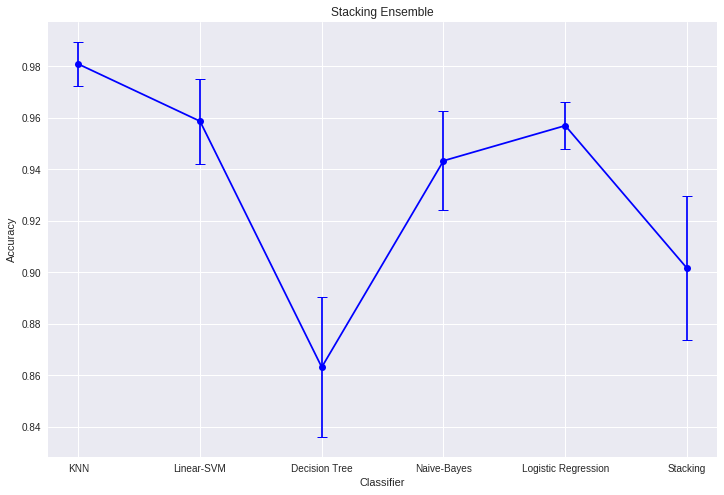

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 3
clf2.C = 0.1
clf3.max_depth = 13
meta_clf.C = 120

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

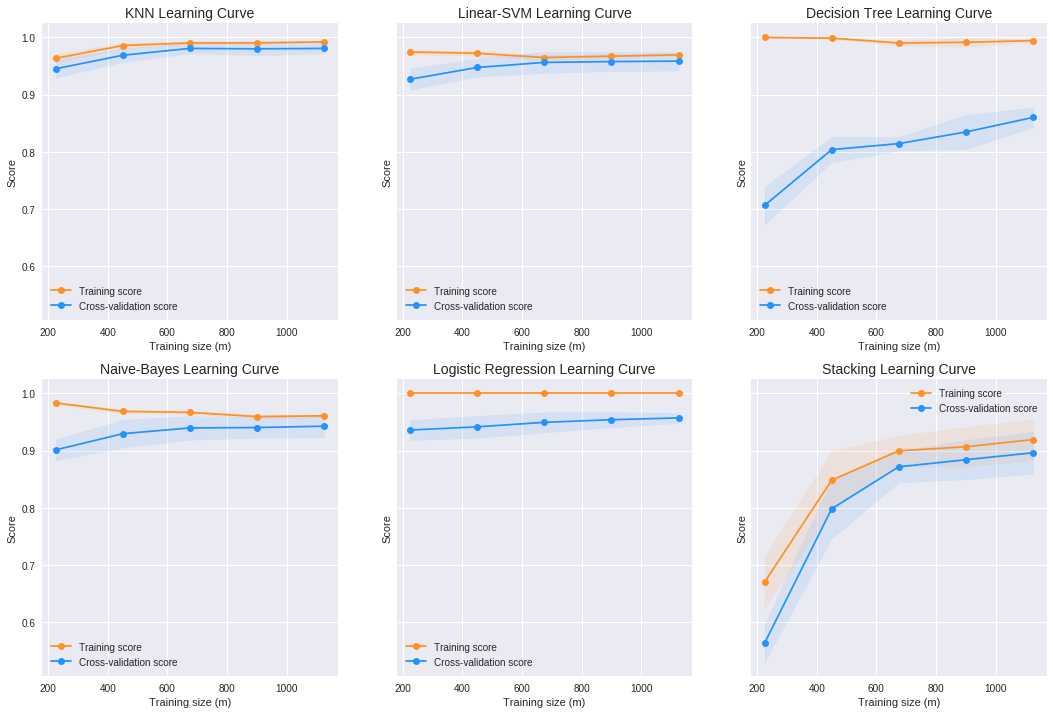

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.8574
Precision      0.8712
Recall         0.8681
F1             0.8586


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 30)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 68.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 75.5min finished


RandomizedSearchCV took 4547.38 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.957 (std: 0.013)
Parameters: {'colsample_bytree': 0.16274379995799326, 'gamma': 0.6860968175599964, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.7596506370397723}

Model with rank: 2
Mean validation score: 0.955 (std: 0.014)
Parameters: {'colsample_bytree': 0.16274379995799326, 'gamma': 0.6860968175599964, 'max_depth': 20, 'min_child_weight': 11, 'subsample': 0.7596506370397723}

Model with rank: 3
Mean validation score: 0.954 (std: 0.016)
Parameters: {'colsample_bytree': 0.1399689347457902, 'gamma': 1.7977851357786754, 'max_depth': 17, 'min_child_weight': 8, 'subsample': 0.7596506370397723}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(7, 9),
          'gamma': [0.66, 0.7, 0.02],
          'max_depth': range(10, 13)}
xgb_clf.subsample = 0.75
xgb_clf.colsample_bytree = 0.16

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 29.1min finished


GridSearchCV took 1765.00 seconds.
Model with rank: 1
Mean validation score: 0.965 (std: 0.010)
Parameters: {'gamma': 0.02, 'max_depth': 10, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.965 (std: 0.010)
Parameters: {'gamma': 0.02, 'max_depth': 11, 'min_child_weight': 7}

Model with rank: 1
Mean validation score: 0.965 (std: 0.010)
Parameters: {'gamma': 0.02, 'max_depth': 12, 'min_child_weight': 7}




### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 7
xgb_clf.gamma = 0.02
xgb_clf.max_depth = 10

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9648
Precision      0.9653
Recall         0.9652
F1             0.9648



# Teaching Assistant Evaluation



## Prepare the dataset.


In [0]:

# Read the dataset.
url="https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')))

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Split to training and test pairs.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

# Scale data.
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

## Bagging

In [0]:
# Define a Decision Tree classifier for the ensemble.
clf = DecisionTreeClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation, for the classifier which will be used in the bagging.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(1, 30),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'criterion': ['gini', 'entropy']}
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1364 tasks      | elapsed:   13.5s


RandomizedSearchCV took 19.71 seconds for 200 candidates.
Model with rank: 1
Mean validation score: 0.909 (std: 0.016)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.905 (std: 0.021)
Parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 56, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.905 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 21, 'max_features': 17, 'min_samples_split': 70}



[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   19.6s finished


### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(19, 23),
              'max_features': range(15, 18),
              'min_samples_split': range(65, 75),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   11.6s


GridSearchCV took 28.87 seconds.
Model with rank: 1
Mean validation score: 0.907 (std: 0.011)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 69}

Model with rank: 2
Mean validation score: 0.906 (std: 0.013)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 15, 'min_samples_split': 66}

Model with rank: 2
Mean validation score: 0.906 (std: 0.008)
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 17, 'min_samples_split': 69}



[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   28.8s finished



### Create the Bagging Ensemble.
Create the Bagging Ensemble, using the best parameters found from the above procedure.  
Since the mean accuracy is the same, we are using the best scores with the minimum std, between the different CV folds.  
We make prediction to the test data, which were left out at the train-test-split procedure and not to the training data again.  
We are using a 10 fold cross validation method, in order to visualize the best number of classifiers.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

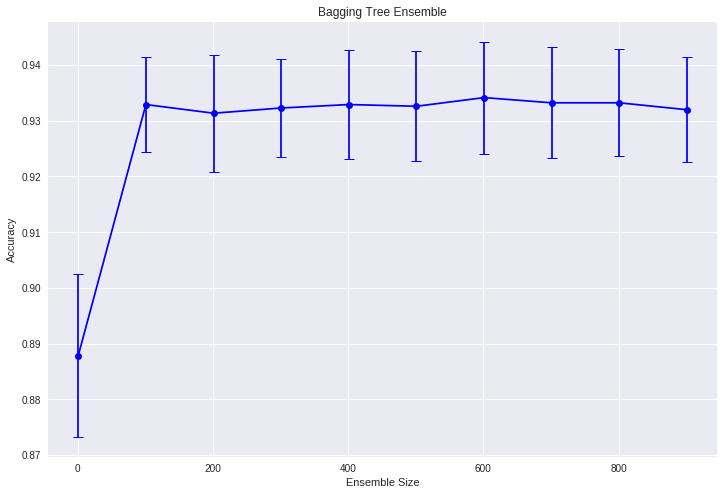

In [0]:

# Add best values for the classifier.
clf.max_depth = 20
clf.max_features = 17
clf.min_samples_split = 69
clf.criterion = 'entropy'

# Plot accuracy vs number of estimators.
estimators_vs_acc(clf, X_train, y_train, estimators_array=range(1, 1000, 100))

### Predict
Predict using the best number of classifiers, based on the previous cross validation method.  
The best number of estimators seems to be 600, since the accuracy is high,  
the lower bound of it's deviation is better than the others and the higher bound, is the best.

In [0]:
# Create the bagging classifier.
bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=600, random_state=0)

# Fit and predict.
bg_clf.fit(X_train, y_train)
y_pred = bg_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9268
Precision      0.9227
Recall         0.9262
F1             0.9243


## Random Forest

In [0]:
# Define a Random Forest classifier.
clf = RandomForestClassifier(random_state=0)

### Random Search
Run a Random Search using 10 fold cross validation.

In [0]:

# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'max_depth': sp_randint(2, 50),
              'max_features': sp_randint(1, X.shape[1]),
              'min_samples_split': sp_randint(2, X.shape[0] / 2),
              'n_estimators': sp_randint(20, 300),
              'criterion': ['gini', 'entropy']}
candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(clf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=8, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)



Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


RandomizedSearchCV took 521.33 seconds for 50 candidates.
Model with rank: 1
Mean validation score: 0.933 (std: 0.035)
Parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 31, 'min_samples_split': 26, 'n_estimators': 245}

Model with rank: 2
Mean validation score: 0.930 (std: 0.035)
Parameters: {'criterion': 'gini', 'max_depth': 38, 'max_features': 14, 'min_samples_split': 118, 'n_estimators': 76}

Model with rank: 3
Mean validation score: 0.926 (std: 0.036)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 7, 'min_samples_split': 253, 'n_estimators': 197}



### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [0]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(22, 24),
              'max_features': range(30, 32),
              'min_samples_split': range(25, 27),
              'n_estimators': range(240, 250, 5),
              'criterion': ['entropy', 'gini']}

# Run a grid search CV.
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=8,
                           iid=True)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


### Predict using the Random Forest Ensemble.
Make prediction with the Random Forest Ensemble, using the best parameters found from the above procedure.


In [0]:

# Add best values for the classifier.
clf.max_depth = 22
clf.max_features = 31
clf.min_samples_split = 25
clf.n_estimators = 240
clf.criterion = 'entropy'
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9232
Precision      0.9184
Recall         0.9240
F1             0.9208


## Stacking

In [0]:
# Define the stacking classifier.
clf1 = KNeighborsClassifier()
clf2 = LinearSVC(random_state=0)
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GaussianNB()
meta_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', 
                              random_state=0)
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], 
                            meta_classifier=meta_clf)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
param_dist = {'kneighborsclassifier__n_neighbors': sp_randint(1, 100),
              'linearsvc__C': [0.01, 0.1, 1, 10, 100],
              'decisiontreeclassifier__max_depth': sp_randint(2, 60),
              'meta-logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000]}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(sclf, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=9, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds, for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11

RandomizedSearchCV took 700.06 seconds, for 50 candidates.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 71, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 2
Mean validation score: 0.930 (std: 0.016)
Parameters: {'decisiontreeclassifier__max_depth': 22, 'kneighborsclassifier__n_neighbors': 22, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 27, 'kneighborsclassifier__n_neighbors': 55, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}

Model with rank: 3
Mean validation score: 0.930 (std: 0.017)
Parameters: {'decisiontreeclassifier__max_depth': 21, 'kneighborsclassifier__n_neighbors': 17, 'linearsvc__C': 100, 'meta-logisticregression__C': 100}



### Grid Search

In [0]:
# Specify parameter_grid for the search.
param_grid = {'kneighborsclassifier__n_neighbors': range(69, 72),
              'linearsvc__C': range(8, 12, 2),
              'decisiontreeclassifier__max_depth': range(16, 18),
              'meta-logisticregression__C': [0.5, 1, 1.5]}

# Run a grid search CV.
grid_search = GridSearchCV(sclf, param_grid, cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'.format((time.time() - start)))
report(grid_search.cv_results_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


GridSearchCV took 544.48 seconds.
Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 0.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 8, 'meta-logisticregression__C': 1.5}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighborsclassifier__n_neighbors': 69, 'linearsvc__C': 10, 'meta-logisticregression__C': 1}

Model with rank: 1
Mean validation score: 0.931 (std: 0.015)
Parameters: {'decisiontreeclassifier__max_depth': 17, 'kneighbor

### Plot stacking results

In [0]:
# Use best values for the classifier.
clf1.n_neighbors = 69
clf2.C = 8
clf3.max_depth = 17
meta_clf.C = 0.5

# Plot accuracy +- std for each model separately
# and compare it with the stacking model.
clf_names = ['KNN', 'Linear-SVM', 'Decision Tree', 'Naive-Bayes',
             'Logistic Regression', 'Stacking']
models = clf1, clf2, clf3, clf4, meta_clf, sclf
plot_accuracy_stacking(clf_names, models, X_train, y_train)

*Note:* in this case, the Naive Bayes classifier seems to affect negatively the total performance of the model.

In [0]:
# Plot the learning curves.
plot_learning_curve(models, clf_names, X_train, y_train)


### Predict using the Stacking Ensemble.
Create a classification report with the Stacking Ensemble.


In [0]:
# Fit and predict.
sclf.fit(X_train,y_train)
y_pred = sclf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9159
Precision      0.9109
Recall         0.9168
F1             0.9134


## XGBoosting

In [0]:
# Create XGBoost, using LogisticRegression classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.03, n_estimators=600, 
                            objective='binary:logistic', silent=True, nthread=1)

### Random Search

In [0]:
# Specify parameters and distributions to sample from 
# and candidates to be created.
params = {'min_child_weight': sp_randint(4, 30),
          'gamma': np.random.uniform(0.5, 4,size=5),
          'subsample': np.random.uniform(0, 1, size=4),
          'colsample_bytree': np.random.uniform(0, 1, size=4),
          'max_depth': sp_randint(1, 7)}

candidates = 50

# Run a random search CV.
random_search = RandomizedSearchCV(xgb_clf, params, candidates, cv=10,
                                   n_jobs=-1, verbose=5, iid=True)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)


### Grid Search

In [0]:
# Specify parameter_grid for the search.
params = {'min_child_weight': range(13, 15),
          'gamma': [2.4, 2.5, 2.6],
          'max_depth': range(1, 8)}
xgb_clf.subsample = 0.65
xgb_clf.colsample_bytree = 0.68

# Run a grid search CV.
grid_search = GridSearchCV(xgb_clf, params , cv = 10, n_jobs=-1, verbose=5,
                           iid=True)

start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)


*Note:* The Grid Search procedure did not give better accuracy score, but lead to better std.


### Predict using the boosted model.
Make prediction with the XGBoosting method, using the best parameters found from the procedure above.


In [0]:

# Add best values for the classifier.
xgb_clf.min_child_weight = 13
xgb_clf.gamma = 2.4
xgb_clf.max_depth = 3

# Fit and predict.
xgb_clf.fit(X_train,y_train)
y_pred = xgb_clf.predict(X_test)

# Print a classification report.
full_report(y_test, y_pred)

Final Results
---------------------
Accuracy       0.9355
Precision      0.9328
Recall         0.9335
F1             0.9331


# Results
![Comparison Table](Comparison_Table.png)

# Conclusion

TODO